# Manga character generation with DDPM

In this exercise, we will learn to use Denoising Diffusion Probabilistic Models (DDPM) to generate manga-like faces.

Diffusion models are generative models that can generate high-quality data (much better than VAEs) without the instability and training complications of GANs.
Their main drawback is that the generation process is expensive, requiring multiple steps through a deep neural network.

Diffusion models are the main component of many modern systems for generative AI.
Here is a short list of widely known projects using them:
* [DALL-E 2](https://openai.com/index/dall-e-2/) (by OpenAI);
* [Stable Diffusion](https://stability.ai/news/stable-diffusion-public-release) (by Stability AI);
* [Imagen](https://imagen.research.google/) (by Google Research);
* [Sora](https://openai.com/index/sora/) (by OpenAI).


#### Suggested readings

The following are good introductions to the topic:
* [What are diffusion models?](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/) by Lilian Wang;
* [Understanding Diffusion Models: A Unified Perspective](https://arxiv.org/abs/2208.11970) by Calvin Luo;
* [Annotated diffusion](https://huggingface.co/blog/annotated-diffusion): a step by step explanation of the source code;
* [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239) by Ho et al. (original paper on DDPM).


## Denoising Diffusion Probabilistic Models (DDPM)

DDPM model a stochastic process in which noise is gradually added to a starting sample $x_0$. The forward process $x_0 \to x_1 \to \dots \to x_T$ is modeled exactly. Then, the reverse process $x_T \to x_{T-1} \to \dots \to x_0$ is approximated thanks to a deep neural network trained for denoising.

![DDPM process](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/DDPM.png)

Note that, if we take $T$ large enough, $x_T$ can be assumed to be pure noise, and we can take samples of it.
The result of the reverse process is that we will be able to sample $x_0$ as if it was coming from the same unknown distribution represented by the training set.

Details about the two processes will be given during the exercise.


## Setup

Let's start by importing the libraries, and by unpacking the training data into the Colab space. Remeber to set the `PROJECT_DIR` so that it points to the folder where you placed the data.  

In [1]:
import google.colab
google.colab.drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import google.colab
import zipfile

import sys
import os

In [3]:
from google.colab import drive
import zipfile



# Define the path to the ZIP file
zip_file_path = "/content/drive/MyDrive/Colab Notebooks (1)/manga.zip"

# Extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall("/content/manga")

print("Extraction complete.")


Extraction complete.


## Dataset

The training images are a subset of the dataset published [here](https://www.kaggle.com/aadilmalik94/animecharacterfaces). In total, there are 12000 images, each one already scaled down to $64 \times 64$ pixels. The simple `ImageFolder` class in the `torchvision` library can be used to load the dataset.  The dataset will pair the images with a useless label, which we can just ignore.

To reduce computation we will further reduce the size of the images to $32 \times 32$ pixels.  If you have more time, you can try also with the original size.

In [4]:
import os
extraction_path = "/content/manga"
# List the contents of the extraction directory
extracted_files = os.listdir( "/content/manga")
print("Contents of the extraction directory:", extracted_files)


Contents of the extraction directory: ['manga', 'unet.py']


In [5]:
# List the contents of the "manga" directory
manga_path = os.path.join(extraction_path, 'manga')
manga_contents = os.listdir(manga_path)
print("Contents of the 'manga' directory:", manga_contents)


Contents of the 'manga' directory: ['train']


In [6]:
import sys
import os

# Add the extraction directory to the Python path
sys.path.append('/content/manga')

# Now you can import unet
import unet

# Check if the unet module is imported correctly
print("unet module imported successfully.")


unet module imported successfully.


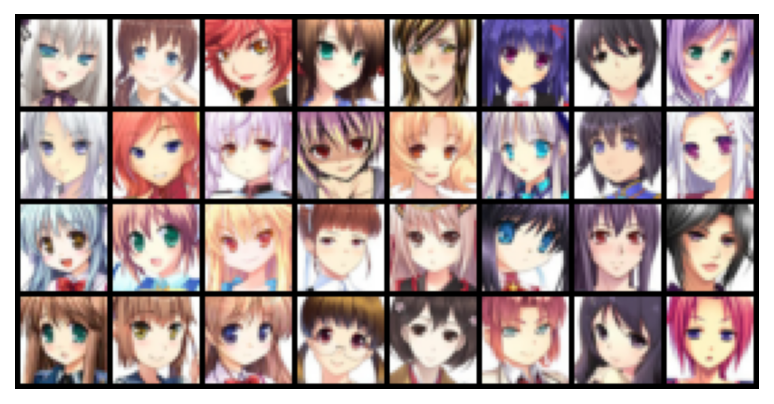

In [7]:
import torch
import torchvision
import matplotlib.pyplot as plt

# Define constants
HEIGHT = WIDTH = 32
BATCH_SIZE = 32

# Define transformations
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((HEIGHT, WIDTH)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0.5, 0.5)
])

# Update the dataset path based on the verified structure
dataset_path = os.path.join(manga_path, "train")  # Adjust this path if necessary

# Define the dataset and the data loader
train_set = torchvision.datasets.ImageFolder(dataset_path, transform=transform)
loader = torch.utils.data.DataLoader(
    train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)

# Function to display a batch of images
def show_faces(faces):
    old = plt.rcParams['figure.dpi']
    plt.rcParams['figure.dpi'] = 150
    g = torchvision.utils.make_grid(faces, normalize=True, value_range=(-1, 1))
    plt.imshow(g.permute(1, 2, 0).detach().cpu())
    plt.axis("off")
    plt.show()
    plt.rcParams['figure.dpi'] = old

# Load and display a batch of images
batch, labels = next(iter(loader))
show_faces(batch)


In [8]:
DEVICE = ("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


## Forward diffusion process

During training we will use the forward process to add noise to training images. This is done in multiple time steps. At time $t = 0$ we have the original image without noise. At the last time step $t = T$ the image is replaced by pure Gaussian noise with zero mean and unit variance. To get to that point we combine the image with a small amount of Gaussian noise, if noise is not scaled down by the squared root then the variance explodes:

$$x_{t} = \sqrt{1 - \beta_t} x_{t-1} + \sqrt{\beta_t}\epsilon$$

where $\epsilon$ is drawn from a Gaussian with zero mean and unit variance. The scalar parameters $\beta_1, \beta_2, \dots, \beta_{T-1}$ define the "variance schedule" of the process.  In fact, adding the same amount of noise at each step is not optimal. Instead, it is more efficient to add more noise close to the end of the forward process, when the image is already very noisy.

In the following it will be useful to define also:
$$\alpha_t = 1 - \beta_t, \; \; \bar\alpha_t = \prod_{i=1}^t \alpha_t.$$

Therefore,
$$x_{t} = \sqrt{\alpha_t} x_{t-1} + \sqrt{1 - \alpha_t}\epsilon$$

In [9]:
TIMESTEPS = 300
beta = torch.linspace(0.0001, 0.02, TIMESTEPS, device=DEVICE) # small beta so at each step the image change by a little
alpha = 1 - beta
alpha_bar = torch.cumprod(alpha, axis=0) # cumulative product, return all alpha bar at each time steps

## Gaussians are nice distributions

The sum of two Gaussian variables is another Gaussian variable, with the sum of means as mean, and the sum of variances as variance.
$$x_t \sim N(\mu_t, \sigma_t^2) \implies \sum_t x_t \sim N(\sum_t \mu_t, \sum_t \sigma_t^2)$$.

Thanks to this property, we can sample x_t by skipping intermediate steps (this will be used for training):
$$\begin{split}
x_t
&= \sqrt{\alpha_{t}} x_{t-1} + \sqrt{1 - \alpha_{t}}\epsilon \\
&= \sqrt{\alpha_{t} \alpha_{t-1}} x_{t-2} + \sqrt{\alpha_{t-1}(1 - \alpha_{t})}\epsilon + \sqrt{1 - \alpha_{t-1}}\epsilon
= \sqrt{\alpha_{t} \alpha_{t-1}} x_{t-2} + \sqrt{1 - \alpha_{t}\alpha_{t-1}}\epsilon \\
&= \dots \\
&= \sqrt{\prod_t\alpha_t} x_0 + \sqrt{1 - \prod_t\alpha_t}\epsilon \\
&=  \sqrt{\bar\alpha_t} x_0 + \sqrt{1 - \bar\alpha_t}\epsilon.
\end{split}$$
Note that each step includes its own noise $\epsilon$, but they can be collapsed into a single random variable

In [10]:
# Sample xt from x0.  When not given, it must be generated with `torch.randn_like`.
# t can be an integer, or a vector of indices.
def q_sample(x0, t, noise=None): # x0 is a batch of images
    t = t.expand(x0.shape[0]) # if t is one number .expand repeat t to get x0.shape[0]
    if noise is None:
        noise = torch.randn_like(x0)
    # Complete using the formula above
    abar  = alpha_bar[t].view(-1, 1, 1, 1) # reshape alpha_bar from vector of length 32 to 4dim with 32 batch and (1,1,1) as the other 3dim
    xt = torch.sqrt(abar)*x0 + torch.sqrt(1-abar)*noise
    return xt

torch.Size([64])


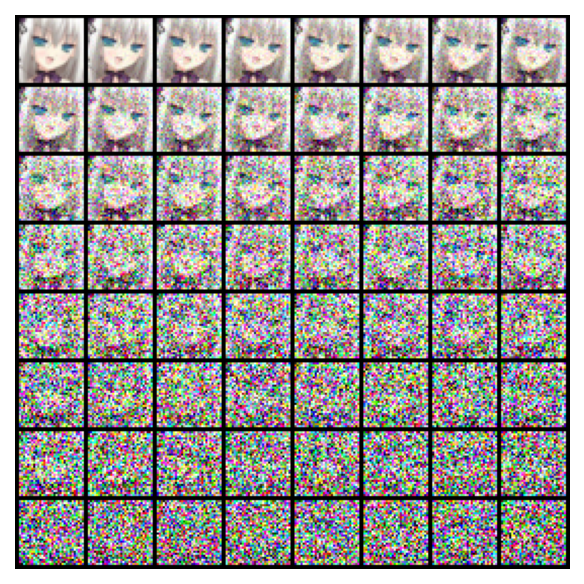

In [11]:
x = batch[0:1].to(DEVICE)
t = torch.linspace(0, TIMESTEPS - 1, 64).long()
print(t.shape)
x_noisy = q_sample(x.repeat(t.shape[0], 1, 1, 1), t) # .repeat(t.shape[0], 1, 1, 1) it means repeat 64 times the image along first dimension and 1,1,1 times along other dimensions
show_faces(x_noisy)

## The neural network

To reverse the process we need to sample $x_{t-1}$ from $x_t$.  This computation is not tractable, and we will approximate it with a neural network.  More precisely, the neural network will take $x_t$ and $t$ as input, and will estimate the noise $\epsilon$ (last equation of the previous paragraph):

$$\epsilon \sim \epsilon_\theta(x_t, t).$$

We will use the same architecture described in the original paper. It is a Unet-like CNN with residual and skip connections, and with attention mechansim. It is provided in the `unet.py` module.   

In [12]:
PROJECT_DIR = "/content/manga/"


In [13]:
import unet

# Parameters:
# - number of features;
# - multipliers for features at each stage;
# - number of channels.
model = unet.Unet(16, (1, 2, 4, 8), 3) # at each steps we have 16*1, 16*2, 16*4, 16*8 features
model.to(DEVICE)
ps = sum(p.numel() for p in model.parameters())
print(f"{ps:,d} parameters")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # 1e-3 a bit large but save training time

def save_model(filename):
    data = {
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict()
    }
    torch.save(data, PROJECT_DIR + filename)

def load_model(filename):
    data = torch.load(PROJECT_DIR + filename)
    model.load_state_dict(data["model"])
    optimizer.load_state_dict(data["optimizer"])

2,430,595 parameters


## Training algorithm

The training algorithm for DDPM is very simple: we take a batch of training samples, we pick random time indices, we generate the noisy samples, use the network to estimate the noise, and compare the actual and estimated noise.

The derivation of the loss function is cumbersome. Empirically, the following simplified loss works well:

$$\mathcal L = \|\epsilon - \epsilon_\theta(x_t, t)\|^2.$$

This is the algorithm taken from the original paper.
![training algorithm](https://huggingface.co/blog/assets/78_annotated-diffusion/training.png)

We will introcue the small variation of using the L1 loss instead of L2.


In [14]:
EPOCHS = 20
LOSS = torch.nn.L1Loss().to(DEVICE)
step = 0
model.to(DEVICE)
model.train()
for epoch in range(EPOCHS):
    for x0, labels in loader:
        optimizer.zero_grad()
        x0 = x0.to(DEVICE)

        # Algorithm 1 line 3: sample t uniformally for every example in the batch
        t = torch.randint(0, TIMESTEPS, (BATCH_SIZE,), device=DEVICE).long()

        # Complete the algorithm, as described above.
        Noise = torch.randn(x0.shape)
        Noise = Noise.to(DEVICE)

        x0 = q_sample(x0, t, noise=Noise)

        estimated_noise = model(x0, t)
        # or loss = (noise - estimated_noise).abs().mean()
        loss = LOSS(estimated_noise, Noise)

        loss.backward()
        optimizer.step()
        step += 1
        if step % 100 == 0:
            print(f"{step} [{epoch}] {loss.item():.4f}")

    save_model("manga-ddpm-tmp.pt")
save_model("manga-ddpm.pt")

100 [0] 0.2787
200 [0] 0.2048
300 [0] 0.2213
400 [1] 0.1827
500 [1] 0.2197
600 [1] 0.2080
700 [1] 0.1606
800 [2] 0.1387
900 [2] 0.1796
1000 [2] 0.2106
1100 [2] 0.1398
1200 [3] 0.1675
1300 [3] 0.2011
1400 [3] 0.1739
1500 [3] 0.1801
1600 [4] 0.1873
1700 [4] 0.1283
1800 [4] 0.1481
1900 [5] 0.1943
2000 [5] 0.1612
2100 [5] 0.1898
2200 [5] 0.2136
2300 [6] 0.1675
2400 [6] 0.1771
2500 [6] 0.1809
2600 [6] 0.1714
2700 [7] 0.1687
2800 [7] 0.1536
2900 [7] 0.1781
3000 [7] 0.1780
3100 [8] 0.1816
3200 [8] 0.1739
3300 [8] 0.1264
3400 [9] 0.1608
3500 [9] 0.1621
3600 [9] 0.1461
3700 [9] 0.2116
3800 [10] 0.1907
3900 [10] 0.1868
4000 [10] 0.1833
4100 [10] 0.1674
4200 [11] 0.1604
4300 [11] 0.1683
4400 [11] 0.1474
4500 [11] 0.1383
4600 [12] 0.1495
4700 [12] 0.1644
4800 [12] 0.1737
4900 [13] 0.1577
5000 [13] 0.1757
5100 [13] 0.1780
5200 [13] 0.1967
5300 [14] 0.1584
5400 [14] 0.1553
5500 [14] 0.1661
5600 [14] 0.1711
5700 [15] 0.1751
5800 [15] 0.1511
5900 [15] 0.2169
6000 [15] 0.1964
6100 [16] 0.1480
6200 [16]

## Sampling

After training, we are ready to generate new images.

We start from $x_T$ sampled from a Gaussian distribution, and sample backward to $x_0$.

The sampling algorithm is:
![sampling algorithm](https://huggingface.co/blog/assets/78_annotated-diffusion/sampling.png)

Note that $z_\theta(x_t, t)$ is the estimated noise for the full $x_0 \to x_t$ process, and it must be properly scaled to obtain $x_{t-1}$. The backward process also requires a seprate variance schedule $\sigma_t^2$.  Here we will use the following:
$$ \sigma_t^2 = \frac{1 - \bar\alpha_{t-1}}{1 - \bar\alpha_t} \beta_t.$$

Note that in the last step the process has no noise.

z_theta is the neural network

In [15]:
sigma = beta * (1 - alpha_bar / alpha) / (1 - alpha_bar)
sigma[0] = 0

@torch.no_grad()
def p_sample(model, x, t):
    b = beta[t].view(-1, 1, 1, 1) ### b = 1 - a
    a = alpha[t].view(-1, 1, 1, 1)
    abar = alpha_bar[t].view(-1, 1, 1, 1)
    s = sigma[t].view(-1, 1, 1, 1)

    Noise = torch.randn_like(x).to(DEVICE)
    model_mean = (x - b*model(x,t)/ torch.sqrt(1 - abar)) / torch.sqrt(a)
    # model_mean = (1/torch.sqrt(a))*(x - (1-a)/torch.sqrt(1-abar)*model(x,t)) not correct
    x_prev =  model_mean + torch.sqrt(s)*Noise
    return x_prev

def sample(model, shape):
    b = shape[0]
    img = torch.randn(shape, device=DEVICE)
    imgs = []

    for i in range(TIMESTEPS - 1, -1, -1): # last -1 means we are going backward
        t = torch.full((b,), i, device=DEVICE).long()
        img = p_sample(model, img, t)
        imgs.append(img.cpu()) # save images in cpu to don't occupy memory of gpu
    return imgs

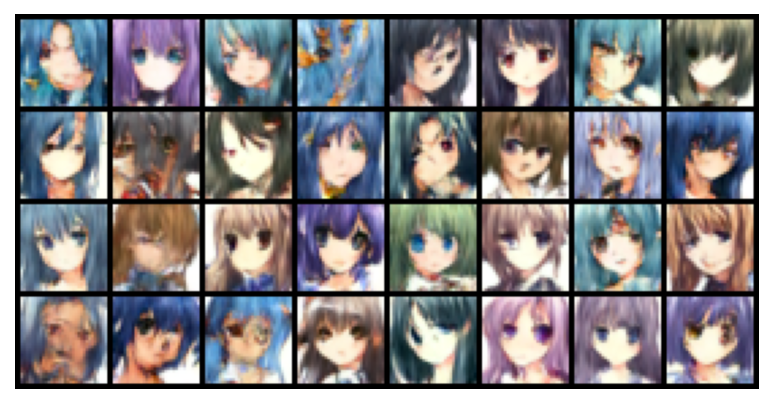

In [16]:
generated = sample(model, (BATCH_SIZE, 3, HEIGHT, WIDTH))
show_faces(generated[299])

color hair is the feature that is most varialbe

by dividing process in steps make training easier

VAE: approximate q(z|x) with p(z) thus there is a tradeoff and the bistriubuitn that i found is not so different, that is why the generated images are similar

## Questions

In the report, answer to the following questions:
* Try changing the number of time steps. What happens? Guess advantages and disadvantages of increasing/reducing that number.
* The reverse process has two source of randomness: the initial $x_T$ and the step noise $z$. Disable them one at a time, and make a hypothesis about their role in the process.

# Task 1: Changing the Number of Time Steps


Sampling with 50 timesteps


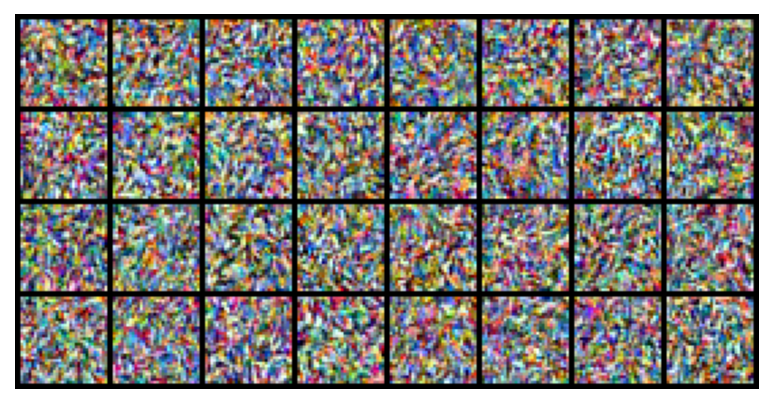

Sampling with 100 timesteps


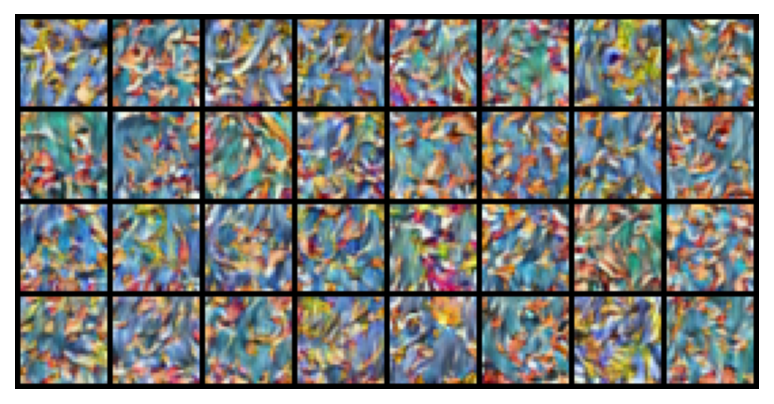

Sampling with 200 timesteps


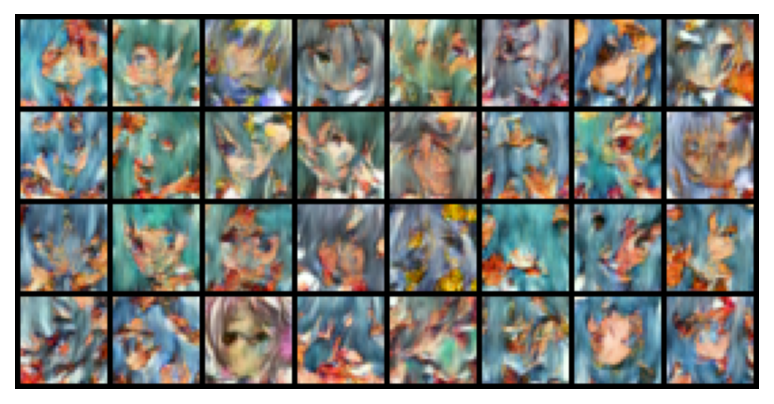

Sampling with 300 timesteps


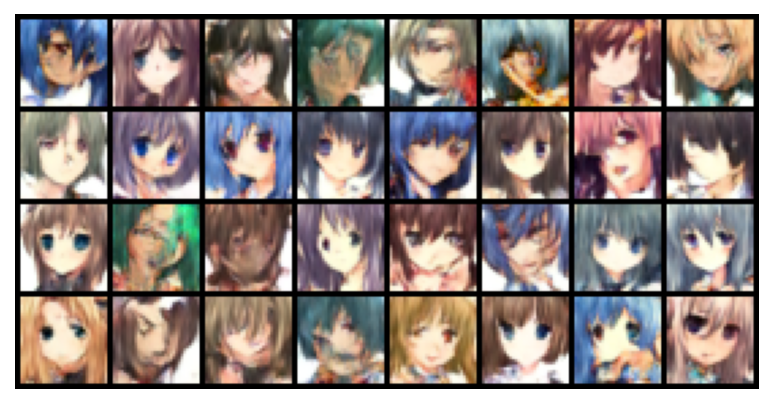

In [17]:
import torch
import torchvision
import matplotlib.pyplot as plt

# Function to display a batch of images
def show_faces(faces):
    old = plt.rcParams['figure.dpi']
    plt.rcParams['figure.dpi'] = 150
    g = torchvision.utils.make_grid(faces, normalize=True, value_range=(-1, 1))
    plt.imshow(g.permute(1, 2, 0).detach().cpu())
    plt.axis("off")
    plt.show()
    plt.rcParams['figure.dpi'] = old

# Function to sample images
@torch.no_grad()
def p_sample(model, x, t):
    b = beta[t].view(-1, 1, 1, 1) ### b = 1 - a
    a = alpha[t].view(-1, 1, 1, 1)
    abar = alpha_bar[t].view(-1, 1, 1, 1)
    s = sigma[t].view(-1, 1, 1, 1)

    Noise = torch.randn_like(x).to(DEVICE)
    model_mean = (x - b*model(x,t)/ torch.sqrt(1 - abar)) / torch.sqrt(a)
    x_prev =  model_mean + torch.sqrt(s)*Noise
    return x_prev

def sample(model, shape, timesteps):
    beta = torch.linspace(0.0001, 0.02, timesteps, device=DEVICE)
    alpha = 1 - beta
    alpha_bar = torch.cumprod(alpha, axis=0)
    sigma = beta * (1 - alpha_bar / alpha) / (1 - alpha_bar)
    sigma[0] = 0

    b = shape[0]
    img = torch.randn(shape, device=DEVICE)
    imgs = []

    for i in range(timesteps - 1, -1, -1): # last -1 means we are going backward
        t = torch.full((b,), i, device=DEVICE).long()
        img = p_sample(model, img, t)
        imgs.append(img.cpu()) # save images in cpu to don't occupy memory of gpu
    return imgs

# Testing with different number of time steps
for timesteps in [50, 100, 200, 300]:
    print(f"Sampling with {timesteps} timesteps")
    generated = sample(model, (BATCH_SIZE, 3, HEIGHT, WIDTH), timesteps)
    show_faces(generated[-1])


# Task 2: Disabling Sources of Randomness

Disabling Initial
𝑥
𝑇

​

We can set the initial
𝑥
𝑇to a fixed tensor of zeros instead of a random tensor.

Sampling with fixed initial x_T


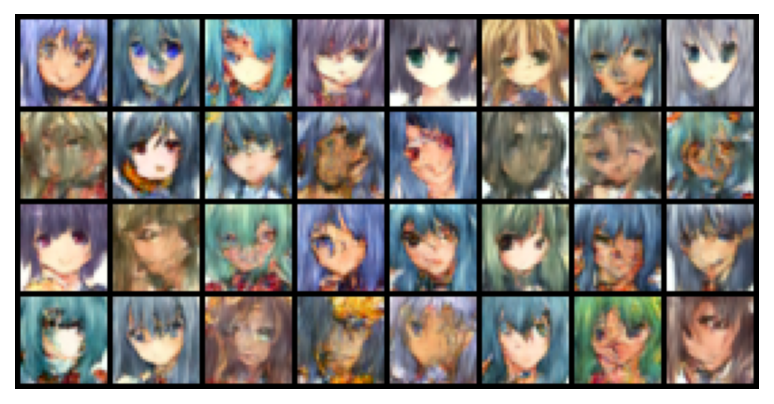

In [18]:
@torch.no_grad()
def sample_fixed_xT(model, shape, timesteps):
    beta = torch.linspace(0.0001, 0.02, timesteps, device=DEVICE)
    alpha = 1 - beta
    alpha_bar = torch.cumprod(alpha, axis=0)
    sigma = beta * (1 - alpha_bar / alpha) / (1 - alpha_bar)
    sigma[0] = 0

    b = shape[0]
    img = torch.zeros(shape, device=DEVICE)  # Fixed initial x_T
    imgs = []

    for i in range(timesteps - 1, -1, -1): # last -1 means we are going backward
        t = torch.full((b,), i, device=DEVICE).long()
        img = p_sample(model, img, t)
        imgs.append(img.cpu()) # save images in cpu to don't occupy memory of gpu
    return imgs

print("Sampling with fixed initial x_T")
generated_fixed_xT = sample_fixed_xT(model, (BATCH_SIZE, 3, HEIGHT, WIDTH), TIMESTEPS)
show_faces(generated_fixed_xT[-1])


# Disabling Step Noise 𝑧

We will set the step noise
𝑧
to zero at each step.

Sampling with no step noise


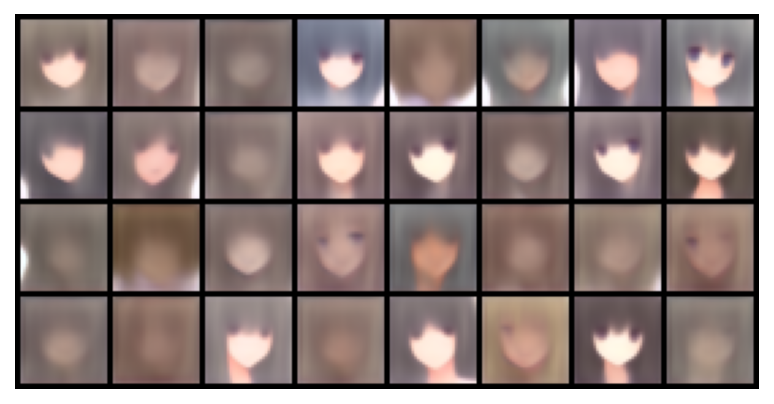

In [19]:
@torch.no_grad()
def p_sample_no_noise(model, x, t):
    b = beta[t].view(-1, 1, 1, 1) ### b = 1 - a
    a = alpha[t].view(-1, 1, 1, 1)
    abar = alpha_bar[t].view(-1, 1, 1, 1)
    s = sigma[t].view(-1, 1, 1, 1)

    Noise = torch.zeros_like(x).to(DEVICE)  # No step noise
    model_mean = (x - b*model(x,t)/ torch.sqrt(1 - abar)) / torch.sqrt(a)
    x_prev =  model_mean + torch.sqrt(s)*Noise
    return x_prev

@torch.no_grad()
def sample_no_step_noise(model, shape, timesteps):
    beta = torch.linspace(0.0001, 0.02, timesteps, device=DEVICE)
    alpha = 1 - beta
    alpha_bar = torch.cumprod(alpha, axis=0)
    sigma = beta * (1 - alpha_bar / alpha) / (1 - alpha_bar)
    sigma[0] = 0

    b = shape[0]
    img = torch.randn(shape, device=DEVICE)
    imgs = []

    for i in range(timesteps - 1, -1, -1): # last -1 means we are going backward
        t = torch.full((b,), i, device=DEVICE).long()
        img = p_sample_no_noise(model, img, t)
        imgs.append(img.cpu()) # save images in cpu to don't occupy memory of gpu
    return imgs

print("Sampling with no step noise")
generated_no_step_noise = sample_no_step_noise(model, (BATCH_SIZE, 3, HEIGHT, WIDTH), TIMESTEPS)
show_faces(generated_no_step_noise[-1])
